# Initialization

In [0]:
# #@markdown - **mount the drive** 
# from google.colab import drive
# drive.mount('GoogleDrive')

In [0]:
# #@markdown - **unmount the drive**
# !fusermount -u GoogleDrive

# Code

In [0]:
#@markdown - **define initialization function**
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as scio
# import time

tf.logging.set_verbosity(tf.logging.ERROR)

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

def glorot_init(shape):
    return tf.truncated_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

def bias_init(shape):
    return tf.random_normal(shape=shape, stddev=.1)

In [30]:
#@markdown - **parameters**
# mnist = input_data.read_data_sets("E:\Anaconda2\Programs\MNIST_data", one_hot=True)
mnist = input_data.read_data_sets('sample_data/MNIST_data', one_hot=True)

# Training Parameters
init_rate = 5e-4 #@param {type: "number"}
decay_steps = 2000 #@param {type: "number"}
num_epochs = 70000 #@param {type: "integer"}
batch_size = 128 #@param {type: "integer"}

# Network Parameters
img_dim = mnist.train.images[0].shape[-1]
gen_hidden_dim = 320
disc_hidden_dim = 320
feature_dim = 196
disc_output_dim = 1

Extracting sample_data/MNIST_data/train-images-idx3-ubyte.gz
Extracting sample_data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting sample_data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting sample_data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
#@markdown - **path**
file_path = 'GoogleDrive/My Drive/Colab Notebooks'
checkpoint_path = os.path.join(file_path, 'Checkpoints')
event_path = os.path.join(file_path, 'Tensorboard')

Epoch 1: Generator Loss: 1.2108, Discriminator Loss: 1.2487.
Epoch 2000: Generator Loss: 6.5151, Discriminator Loss: 0.0032.
Epoch 4000: Generator Loss: 4.4677, Discriminator Loss: 0.0633.
Epoch 6000: Generator Loss: 4.1421, Discriminator Loss: 0.1264.
Epoch 8000: Generator Loss: 4.2345, Discriminator Loss: 0.1506.
Epoch 10000: Generator Loss: 3.7296, Discriminator Loss: 0.2416.
Epoch 12000: Generator Loss: 3.0815, Discriminator Loss: 0.3872.
Epoch 14000: Generator Loss: 2.7211, Discriminator Loss: 0.4707.
Epoch 16000: Generator Loss: 3.1429, Discriminator Loss: 0.3436.
Epoch 18000: Generator Loss: 2.6934, Discriminator Loss: 0.4261.
Epoch 20000: Generator Loss: 2.7410, Discriminator Loss: 0.3947.
Epoch 22000: Generator Loss: 2.4980, Discriminator Loss: 0.3512.
Epoch 24000: Generator Loss: 2.6405, Discriminator Loss: 0.3676.
Epoch 26000: Generator Loss: 2.5286, Discriminator Loss: 0.4629.
Epoch 28000: Generator Loss: 2.6580, Discriminator Loss: 0.4108.
Epoch 30000: Generator Loss: 2.50

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


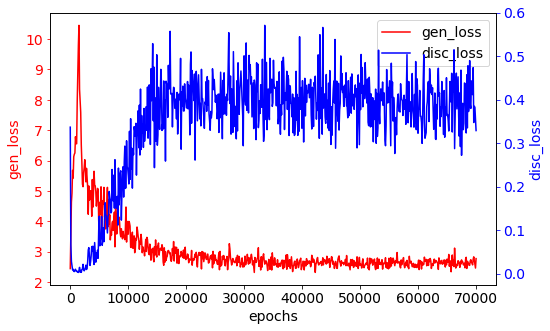

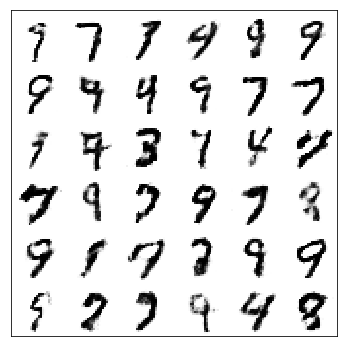

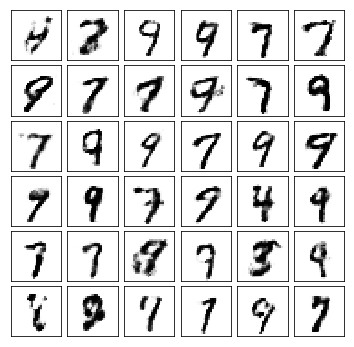

In [32]:
#@markdown - **main code**
graph = tf.Graph()
with graph.as_default():

    global_step = tf.Variable(0, name='global_step', trainable=False)
    # init_rate = FLAGS.learning_rate
    decay_rate = 0.9
    # decay_steps = FLAGS.decay_steps
    learning_rate = tf.train.exponential_decay(init_rate, global_step=global_step,
                                                decay_steps=decay_steps, 
                                                decay_rate=decay_rate, 
                                                staircase=False, 
                                                name='exponential_decay')

    with tf.name_scope('Input'):
        gen_input = tf.placeholder(tf.float32, [None, feature_dim], name='random_noises')
        disc_input = tf.placeholder(tf.float32, [None, img_dim], name='real_images')

    with tf.name_scope('Weights_and_biases'):
        weights = {
            'gen_h': tf.Variable(glorot_init([feature_dim, gen_hidden_dim]), name='gen_w1'),
            'gen_o': tf.Variable(glorot_init([gen_hidden_dim, img_dim]), name='gen_w2'),
            'disc_h': tf.Variable(glorot_init([img_dim, disc_hidden_dim]), name='disc_w1'),
            'disc_o': tf.Variable(glorot_init([disc_hidden_dim, disc_output_dim]), name='disc_w2'),
            }
        biases = {
            'gen_b1': tf.Variable(bias_init([gen_hidden_dim]), name='gen_b1'),
            'gen_b2': tf.Variable(bias_init([img_dim]), name='gen_b2'),
            'disc_b1': tf.Variable(bias_init([disc_hidden_dim]), name='disc_b1'),
            'disc_b2': tf.Variable(bias_init([disc_output_dim]), name='disc_b2'),
            }
    with tf.name_scope('Generator_and_Discriminator'):
        # Building the generator
        def generator(x):
            layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['gen_h']),
                                            biases['gen_b1']))
            layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['gen_o']),
                                            biases['gen_b2']))
            return layer_2

        # Building the discriminator
        def discriminator(x):
            layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['disc_h']),
                                           biases['disc_b1']))
            layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['disc_o']),
                                           biases['disc_b2']))
            return layer_2

    with tf.name_scope('Main_structure'):
        # Construct model
        gen_sample = generator(gen_input)
        gen_imgs = tf.reshape(gen_sample, [-1, 28, 28, 1], name='gen_imgs')
        disc_fake = discriminator(gen_sample)
        disc_real = discriminator(disc_input)

    with tf.name_scope('Loss'):
        gen_loss = -tf.reduce_mean(tf.log(disc_fake + 1e-10))
        disc_loss = -tf.reduce_mean(tf.log(disc_real + 1e-10) + tf.log(1. - disc_fake))

    with tf.name_scope('Train'):
        # Build Optimizers
        optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
        optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)
        # By default in TensorFlow, all variables are updated by each optimizer, so we
        # need to precise for each one of them the specific variables to update.
        # Generator Network Variables
        gen_vars = [weights['gen_h'], weights['gen_o'],
                    biases['gen_b1'], biases['gen_b2']]
        # Discriminator Network Variables
        disc_vars = [weights['disc_h'], weights['disc_o'],
                    biases['disc_b1'], biases['disc_b2']]

        trainop_gen = optimizer_gen.minimize(gen_loss, global_step=global_step, var_list=gen_vars)
        # trainop_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
        trainop_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

    # summaries
    tf.summary.histogram('gen_w1', weights['gen_h'], collections=['gen'])
    tf.summary.histogram('gen_b1', biases['gen_b1'], collections=['gen'])
    tf.summary.histogram('disc_w2', weights['disc_o'], collections=['disc'])
    tf.summary.histogram('disc_b2', biases['disc_b2'], collections=['disc'])
    tf.summary.image('gen_imgs', gen_imgs, collections=['gen'])
    tf.summary.scalar('gen_loss', gen_loss, collections=['gen'])
    tf.summary.scalar('disc_loss', disc_loss, collections=['disc'])
    tf.summary.scalar('global_step', global_step, collections=['gen'])
    tf.summary.scalar('learning_rate', learning_rate, collections=['gen'])

    gen_sum = tf.summary.merge_all('gen')
    disc_sum = tf.summary.merge_all('disc')

    saver = tf.train.Saver(max_to_keep=1)

    sess = tf.Session(graph=graph)
    with sess.as_default():
        # Initialize the variables (i.e. assign their default value)
        sess.run(tf.global_variables_initializer())

        gen_path = os.path.join(event_path, 'gen')
        gen_writer = tf.summary.FileWriter(gen_path)
        gen_writer.add_graph(sess.graph)

        disc_path = os.path.join(event_path, 'disc')
        disc_writer = tf.summary.FileWriter(disc_path)
        disc_writer.add_graph(sess.graph)

        # Start Training
        gen_loss_list = []
        disc_loss_list = []
        for epoch in range(num_epochs):
            batch, _ = mnist.train.next_batch(batch_size)
            random_noise = np.random.uniform(-1., 1., size=[batch_size, feature_dim])
            _, _, l_g, l_d, s_g, s_d = sess.run([trainop_gen, trainop_disc, gen_loss, disc_loss, gen_sum, disc_sum], 
                                                feed_dict={gen_input: random_noise, disc_input: batch})

            # s_g, s_d = sess.run([gen_sum, disc_sum], feed_dict={gen_input: random_noise, 
            #                                                     disc_input: batch})
            gen_writer.add_summary(s_g, global_step=epoch)
            disc_writer.add_summary(s_d, global_step=epoch)
            if (epoch + 1) % 100 == 0:
                gen_loss_list.append(l_g)
                disc_loss_list.append(l_d)
            # # Train a classifier first
            # _, l_d = sess.run([trainop_disc, disc_loss], feed_dict={gen_input: random_noise, 
            #                                                         disc_input: batch})
            # if (epoch+1) % 2 == 0:
            #     _, l_g = sess.run([trainop_gen, gen_loss], feed_dict={gen_input: random_noise,
            #                                                             disc_input: batch})
            print_list = [epoch+1, l_g, l_d]
            if (epoch+1) % 2000 == 0 or (epoch+1) == 1:
                print('Epoch {0[0]}: Generator Loss: {0[1]:.4f}, Discriminator Loss: {0[2]:.4f}.'.format(print_list))

        data_name = os.path.join(event_path, 'loss_data.mat')
        loss_data = {'gen_loss': np.array(gen_loss_list),
                    'disc_loss': np.array(disc_loss_list)}
        # scio.savemat(data_name, loss_data)
        # loss_data = scio.loadmat(data_name)
        x_data = np.linspace(1, num_epochs + 1, num_epochs / 100)
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
        par1 = ax.twinx()
        p1, = ax.plot(x_data, loss_data['gen_loss'], 'r', label='gen_loss')
        p2, = par1.plot(x_data, loss_data['disc_loss'], 'b', label='disc_loss')
        ax.set_xlabel('epochs', fontsize=14)
        ax.set_ylabel('gen_loss', fontsize=14)
        par1.set_ylabel('disc_loss', fontsize=14)
        ax.yaxis.label.set_color(p1.get_color())
        par1.yaxis.label.set_color(p2.get_color())
        ax.tick_params(axis='y', colors=p1.get_color(), labelsize=14)
        par1.tick_params(axis='y', colors=p2.get_color(), labelsize=14)
        ax.tick_params(axis='x', labelsize=14)
        lines = [p1, p2]
        ax.legend(lines, [l.get_label() for l in lines], fontsize=14, loc='upper right')
        img_name = os.path.join(event_path, 'gen_loss_and_disc_loss.jpg')
        plt.savefig(img_name)
        plt.show()

        # Generate images from noise, using the generator network.
        n = 6
        canvas = np.empty((28 * n, 28 * n))
        for i in range(n):
            # Noise input.
            z = np.random.uniform(-1., 1., size=[n, feature_dim])
            # Generate image from noise.
            g = sess.run(gen_sample, feed_dict={gen_input: z})
            # Reverse colours for better display
            g = -1 * (g - 1)
            for j in range(n):
                # Draw the generated digits
                canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(n, n))
        ax.imshow(canvas, cmap='gray')
        ax.set_xticks([]), ax.set_yticks([])
        img_name1 = os.path.join(event_path, 'generated_images_by_GAN1.jpg')
        plt.savefig(img_name1)
        plt.show()

        fig, AX = plt.subplots(nrows=6, ncols=6, figsize=(6, 6))
        fig.subplots_adjust(wspace=0.1, hspace=0.1)
        # Noise input.
        z = np.random.uniform(-1., 1., size=[36, feature_dim])
        # Generate image from noise.
        g = sess.run(gen_sample, feed_dict={gen_input: z})
        g = (1 - g)
        for i in range(6):
            for j in range(6):
                ax = AX[i, j]
                ax.imshow(g[i*6 + j].reshape([28, 28]), 'gray')
                ax.set_xticks([]), ax.set_yticks([])
        img_name2 = os.path.join(event_path, 'generated_images_by_GAN2.jpg')
        plt.savefig(img_name2)
        plt.show()


    gen_writer.close()
    disc_writer.close()
    sess.close()

In [0]:
!tensorboard --logdir='GoogleDrive/My Drive/Colab Notebooks/Tensorboard'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


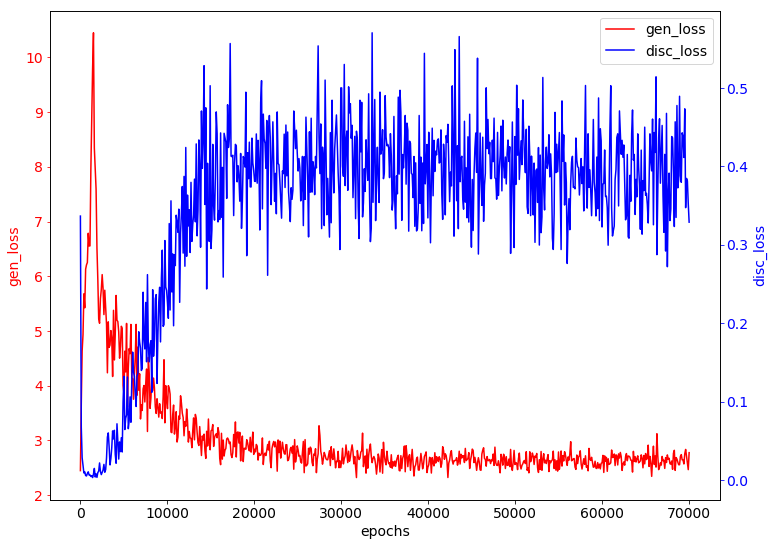

In [36]:
#@markdown - **plot gen_loss and disc_loss**
scio.savemat(data_name, loss_data)
# loss_data = scio.loadmat(data_name)
x_data = np.linspace(1, num_epochs + 1, num_epochs / 100)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))
par1 = ax.twinx()
p1, = ax.plot(x_data, loss_data['gen_loss'], 'r', label='gen_loss')
p2, = par1.plot(x_data, loss_data['disc_loss'], 'b', label='disc_loss')
ax.set_xlabel('epochs', fontsize=14)
ax.set_ylabel('gen_loss', fontsize=14)
par1.set_ylabel('disc_loss', fontsize=14)
ax.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
ax.tick_params(axis='y', colors=p1.get_color(), labelsize=14)
par1.tick_params(axis='y', colors=p2.get_color(), labelsize=14)
ax.tick_params(axis='x', labelsize=14)
lines = [p1, p2]
ax.legend(lines, [l.get_label() for l in lines], fontsize=14, loc='upper right')
img_name = os.path.join(event_path, 'gen_loss_and_disc_loss.jpg')
plt.savefig(img_name)
plt.show()